# Einsums in the wild

In [1]:
import jax
import numpy
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
seed = 314

## The basics

$$
    x^T A x = \sum_{i,j} x_i A_{i,j} x_j
$$

So that we can write `n,nm,m->` to mention that we are summing over all values

In [4]:
x = jnp.array([1, 3])
A = jnp.array([[1, -2], [-3, 2]])

In [5]:
x.T @ A @ x

DeviceArray(4, dtype=int32)

In [6]:
jnp.einsum("i,ij,j->", x, A, x)

DeviceArray(4, dtype=int32)

If we were to have $N$ such observations, we usually store it a matrix ${\bf X} \in \mathbb{R}^{N\times M}$. So that if we wanted to compute for every row $n$, ${\bf x}_n^T A {\bf x}_n$ the operation $X^T A X$ would not work. We could, however, compute the following

$$
    \text{diag}({\bf X}^T {\bf A} {\bf X})
$$

In [7]:
key = jax.random.PRNGKey(seed)

N = 10
X = jax.random.randint(key, shape=(N, 2), minval=-5, maxval=5)

In [8]:
jnp.diag(X @ A @ X.T)

DeviceArray([ 16,  64, 134,  -2,  72,  -8, -13, -18, -50, -18], dtype=int32)

If we use einsums, to compute $\forall n. {\bf x}_n^T {\bf A} {\bf x}_n$ all we need is to add an additional index to our einsum to express a *constant* dimension: `ni,ij,nj->n`.

We went from `i,ij,j->` to `ni,ij,nj->n`. This is an important remark using einsums: having an *atomic* expression in einsum form is easy to generalise for multiple dimensions. This is not usually the case in vector-matrix form.

In [9]:
jnp.einsum("ni,ij,nj->n", X, A, X)

DeviceArray([ 16,  64, 134,  -2,  72,  -8, -13, -18, -50, -18], dtype=int32)

In [10]:
# permutation invariant: product is commutative
jnp.einsum("ni,nj,ij->n", X, X, A)

DeviceArray([ 16,  64, 134,  -2,  72,  -8, -13, -18, -50, -18], dtype=int32)

In [11]:
# permutation invariant: product is commutative
jnp.einsum("ij,ni,nj->n", A, X, X)

DeviceArray([ 16,  64, 134,  -2,  72,  -8, -13, -18, -50, -18], dtype=int32)

### Going deeper

* `i,ij,j->`: scalar output
* `ni,ij,nj->n`: 1-dimensional output
* `nmi,ij,nmj->nm`: 2-dimensional output
* `nmli,ij,nmlj->nml`: 3-dimensional output
* `...i,ij,...j->...`: n-dimensional output

In [12]:
N1, N2, N3, N4 = 2, 4, 2, 3

X_dense = jax.random.randint(key, shape=(N1, N2, N3, N4, 2), minval=-5, maxval=5)
jnp.einsum("...i,ij,...j->...", X_dense, A, X_dense)

DeviceArray([[[[ -4,  13,  -1],
               [-32,  -4,  -1]],

              [[ 16,  38, -16],
               [ -8,  -4,  16]],

              [[-17, -18, -18],
               [-18,  32, 101]],

              [[-13, -50, -13],
               [ 16,  13,  34]]],


             [[[  4, -32,  76],
               [ -8,   9,  38]],

              [[ 72,  -8,  32],
               [ -4,   4, -19]],

              [[ -2, 157, 128],
               [134,   0,  47]],

              [[-13, 101,  -2],
               [  2,   2, 118]]]], dtype=int32)

# Log-density of a normal distribution

Let  $x\sim\mathcal{N}(\mu, \Sigma)$, then the log-density of $x$ is given by

$$
    \log p({\bf x} \vert \boldsymbol\mu, \Sigma) = -\frac{1}{2}({\bf x} - \boldsymbol\mu)^T\Sigma^{-1}({\bf x} - \boldsymbol\mu) + \text{cst.}
$$

Suppose we want to plot the log-density of a Gaussian distribution up to a constant. As we have previously seen, the expression $x^T A x$ can be represented in einsum form as `i,ij,j->`. A common way to plot this joint-density for a 2-dimensional gaussian is obtain a tuple (x,y) of elements in a grid. This is commonly done using `np.mgrid`.

In [13]:
mean_vec = jnp.array([1, 0]) 
prec_matrix = jnp.array([[4, -2], [-2, 4]])
prec_matrix = jnp.linalg.inv(prec_matrix)

step = 0.1
xmin, xmax = -8, 8
ymin, ymax = -10, 10
X_grid = jnp.mgrid[xmin:xmax:step, ymin:ymax:step] + mean_vec[:, None, None]
X_grid.shape

(2, 160, 200)

The variable `X_grid` defined above has three dimensions: `i,n,m`. We let `i` be the dimension corresponding to the elements in the xy-plane given by `n` and `m` respectively. Plotting the log-density is just a matter of using an expression we've already seen:

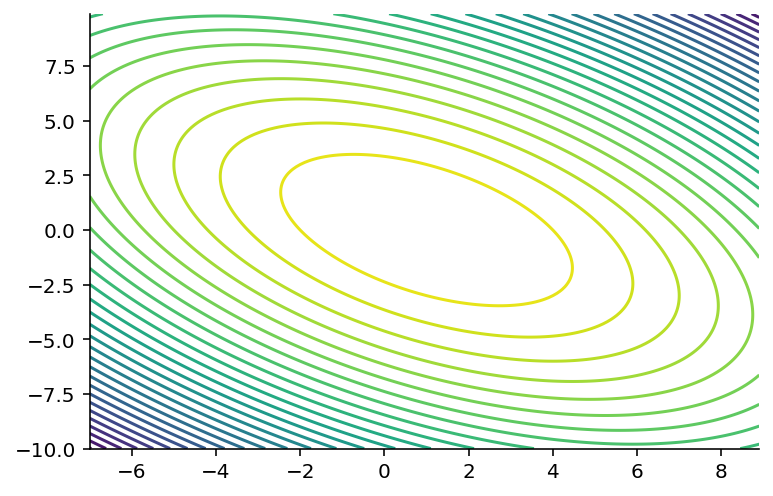

In [20]:
diff_grid = (X_grid - mean_vec[:, None, None])
log_prob_grid = -jnp.einsum("inm,ij,jnm->nm", diff_grid, prec_matrix, diff_grid) / 2
plt.contour(*X_grid, log_prob_grid, 30)
plt.savefig("gaussian.png", dpi=200)

We could expand this previous idea to the case of a set of multivariate Gaussians with constant mean and multiple covariance matrices. This idea will be important in the mixture-of-Gaussian's example.

Recall that the einsum expression to compute the density of a multivariate normal over a region $\mathcal X \subseteq \mathbb{R}^M$ is given by `inm,ij,jnm->nm`. Assuming that we have a set of $K$ Gaussian distributions, each with distinct precision matrices $\{S_k\}_{k=1}^K$ and same mean $\boldsymbol\mu \in \mathbb{R}^M$, to compute the density over each of the regions we simply modify our previous expression to take account of the new *static* dimension. That is, we obtain `inm,kij,jnm->knm`

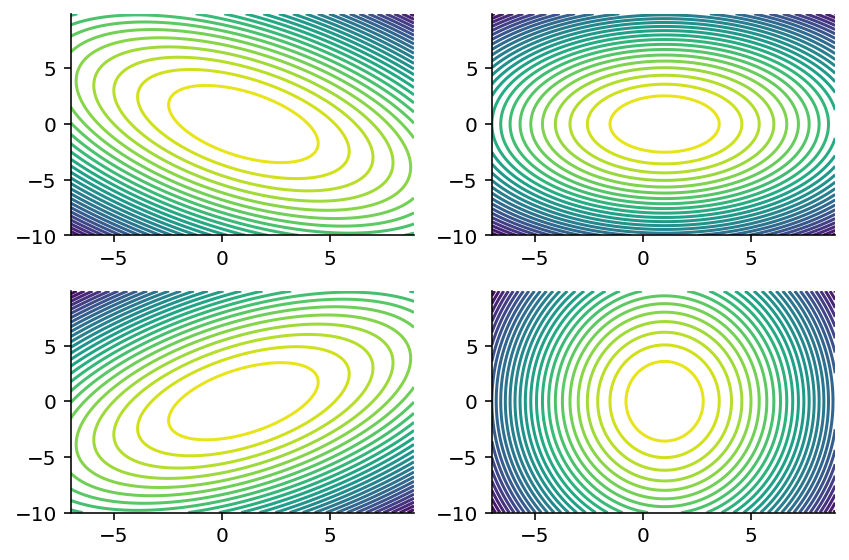

In [18]:
C1 = jnp.array([
    [4, -2],
    [-2, 4]
])

C2 = jnp.array([
    [4, 0],
    [0, 4]
])

C3 = jnp.array([
    [4, 2],
    [2, 4]
])


C4 = jnp.array([
    [1, -2],
    [2, 4]
])

C = jnp.stack([C1, C2, C3, C4], axis=0)
# Precision matrix
S = jnp.linalg.inv(C)

log_prob_grid_multiple = -jnp.einsum("inm,kij,jnm->knm", diff_grid, S, diff_grid) / 2

fig, ax = plt.subplots(2, 2)
ax = ax.ravel()

for axi, log_prob_grid in zip(ax, log_prob_grid_multiple):
    axi.contour(*X_grid, log_prob_grid, 30)
plt.tight_layout()
plt.savefig("k-gaussians.png", dpi=200)

## Predictive surface of a logistic regression model

As long as the inner-most operation we want to compute consists of a linear combination of elements, we can make use of einsums. As a second example, consider the estimation of the predictive surface of a logistic regression with Gaussian prior. That is, we want to compute

$$
\begin{aligned}
    p(\hat y = 1 \vert {\bf x}) &= \int_{\mathbb{R}^2} \sigma({\bf w}^T {\bf x}) p({\bf w} \vert \mathcal{D}) d{\bf w}\\ 
  &= \mathbb{E}_{{\bf w} \vert \mathcal{D}}\big[\sigma({\bf w}^T {\bf x})\big]\\
  &\approx \frac{1}{S} \sum_{s=1}^S \sigma\left({\bf w^{(s)}}^T {\bf x}\right)
\end{aligned}
$$

Suppose we've already estimated the posterior parameters $\hat{\bf w}, \hat\Sigma$. Since the posterior predictive distribution is intractable to compute analytically, we turn to a Monte Carlo approximation of the posterior predictive surface. As with the MVG case, we want to compute $p(\hat y = 1 \vert {\bf x})$ over a surface $\mathcal X \subseteq \mathbb{R}^M$.

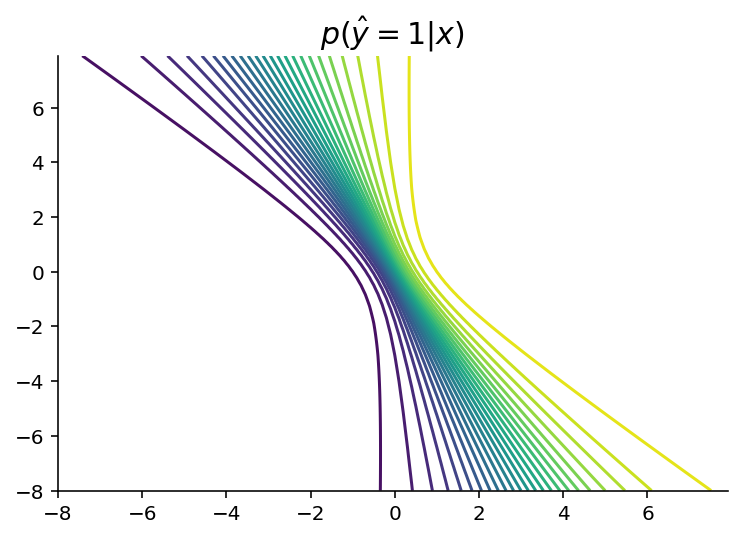

In [33]:
# Estimated posterior mean and covariance matrix
w_hat = jnp.array([4.29669692, 1.6520908])
S_hat = jnp.array([[2.74809243, 0.76832627],
                [0.76832627, 0.88442754]])

C_hat = jnp.linalg.inv(S_hat)

n_samples = 1_000

boundary = 8
X_grid = jnp.mgrid[-boundary:boundary:step, -boundary:boundary:step]

w_samples = jax.random.multivariate_normal(key, w_hat, S_hat, shape=(n_samples,))

logit_grid = jnp.einsum("sm,mij->sij", w_samples, X_grid)
P_grid = jax.nn.sigmoid(logit_grid).mean(axis=0)
plt.contour(*X_grid, P_grid, 30)
plt.title(r"$p(\hat y = 1 \vert x)$", fontsize=15);
plt.savefig("bayesian-logistic-reg.png", dpi=200)

## Singular value decomposition (SVD)

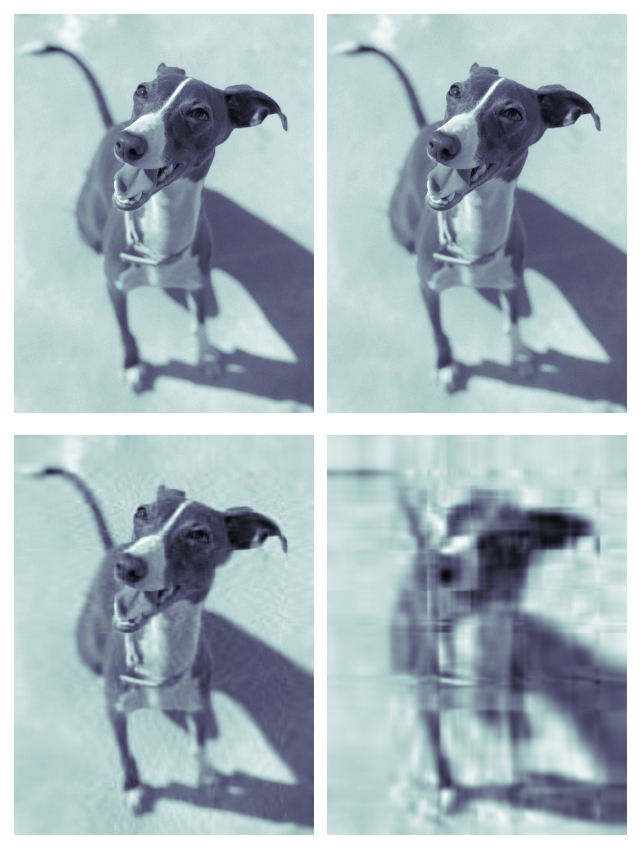

In [156]:
from jax.numpy.linalg import svd

img = plt.imread("/Users/gerardoduran/Desktop/dump/bimba.jpg")

c_weights = jnp.array([0.2989, 0.5870, 0.1140])
img_gray = jnp.einsum("c,ijc->ij", c_weights, img)
U, s, Vh = jax.scipy.linalg.svd(img_gray, full_matrices=False)

indexer = s[:, None] > jnp.array([10, 100, 1_000, 5_000])
img_svd_collection = jnp.einsum("ni,i,im,ik->knm", U, s, Vh, indexer)

fig, ax = plt.subplots(2, 2, figsize=(5, 6))
ax = ax.ravel()
for axi, img_svd in zip(ax, img_svd_collection):
    axi.imshow(img_svd, cmap="bone")
    axi.axis("off")
plt.tight_layout(w_pad=-1)

# References 
1. https://www.delftstack.com/howto/python/convert-image-to-grayscale-python/